In [1]:
import os
import json
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
from glob import glob
from tqdm import tqdm

In [2]:
### Audio
audio, sr = librosa.load("/Users/virgile/data/vad_data/1246-124548-0018.wav", sr=16000)

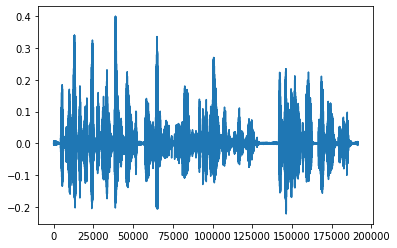

In [3]:
plt.plot(audio)

In [4]:
### Annotations

In [5]:
target = json.load(open("/Users/virgile/data/vad_data/1246-124548-0018.json", 'r'))
print(json.dumps(target, indent=4))

{
    "speech_segments": [
        {
            "start_time": 0.21,
            "end_time": 0.42
        },
        {
            "start_time": 0.42,
            "end_time": 0.71
        },
        {
            "start_time": 0.71,
            "end_time": 1.1099999999999999
        },
        {
            "start_time": 1.11,
            "end_time": 1.61
        },
        {
            "start_time": 1.64,
            "end_time": 1.89
        },
        {
            "start_time": 1.9,
            "end_time": 2.32
        },
        {
            "start_time": 2.32,
            "end_time": 2.82
        },
        {
            "start_time": 2.82,
            "end_time": 3.3099999999999996
        },
        {
            "start_time": 3.52,
            "end_time": 3.75
        },
        {
            "start_time": 3.75,
            "end_time": 3.97
        },
        {
            "start_time": 3.97,
            "end_time": 4.25
        },
        {
            "start_time": 4.25,
  

In [138]:
def get_df_from_json(json_path:str, min_length:float=0.01)->pd.DataFrame:
    """
    Generates a Dataframe containing utterrances infos from json annotations

    Args:
        json_path (str): path to json file containing annotations

    Returns:
        pd.DataFrame: Annotation in the form of Dataframe
    """
    data = json.load(open(json_path, 'r'))

    speech_df = pd.DataFrame(data['speech_segments'])
    speech_df['utt_time'] = ""
    speech_df['speech'] = 1
    speech_df['start_time'] = np.round(speech_df['start_time'].astype(float),3)
    speech_df['end_time'] = np.round(speech_df['end_time'].astype(float),3)

    utt_times = []
    # Add start and stops for non_speech:
    for i in range(len(speech_df)-1):
        if abs(speech_df.iloc[i]['end_time'] - speech_df.iloc[i+1]['start_time']) > 0.01:
            speech_df = speech_df.append({'start_time':speech_df.iloc[i]['end_time'], 
                                          'end_time':speech_df.iloc[i+1]['start_time'],
                                          'speech':0}, ignore_index=True)

    # Add utterances times
    utt_times = []
    for i in range(len(speech_df)):
        utt_times.append(np.round(speech_df.iloc[i]['end_time'] - speech_df.iloc[i]['start_time'], 3))
    speech_df['utt_time'] = utt_times

    # Sort DF
    speech_df = speech_df.sort_values(by='start_time').reset_index(drop=True)
    # Add audio ID
    speech_df['audio_id'] = json_path.replace('.json', '.wav')


    return speech_df

In [139]:
df = get_df_from_json("/Users/virgile/data/vad_data/1246-124548-0018.json")
df.head()

,start_time,end_time,utt_time,speech,audio_id
0,0.21,0.42,0.21,1.0,/Users/virgile/data/vad_data/1246-124548-0018.wav
1,0.42,0.71,0.29,1.0,/Users/virgile/data/vad_data/1246-124548-0018.wav
2,0.71,1.11,0.40,1.0,/Users/virgile/data/vad_data/1246-124548-0018.wav
3,1.11,1.61,0.50,1.0,/Users/virgile/data/vad_data/1246-124548-0018.wav
4,1.61,1.64,0.03,0.0,/Users/virgile/data/vad_data/1246-124548-0018.wav


In [140]:
def get_consolidated_dataframe(json_data_path:str)->pd.DataFrame:
    """
    Get consolidated data for speech and non-speech utterances in the form of a Dataframe.
    - For each json annotation, get its corresponding Dataframe
    - Concatenate all Dataframe

    Args:
        json_data_path (str): Path to folder containing JSON annotations

    Returns:
        pd.DataFrame: Consolidated Dataframe
    """

    list_json = glob(json_data_path + '*.json')
    
    speech_dfs = []
    for k in tqdm(list_json):
        speech_df = get_df_from_json(k)
        speech_dfs.append(speech_df)

    speech_df = pd.concat(speech_dfs).reset_index(drop=True)
    
    return speech_df

In [141]:
speech_df = get_consolidated_dataframe(json_data_path='/Users/virgile/data/vad_data/')

100%|██████████| 957/957 [00:29<00:00, 32.23it/s]


In [142]:
print(speech_df[speech_df['speech']==1].utt_time.sum())
print(speech_df[speech_df['speech']==0].utt_time.sum())


9519.91
1701.56


In [144]:
# Let's add 7819 seconds of (noisy) silence


7819

In [84]:
speech_df

,start_time,end_time,utt_time,speech,audio_id
0,0.660000,0.800000,0.140000,1.0,/Users/virgile/data/vad_data/1040-133433-0060.wav
1,0.800000,0.930000,0.130000,1.0,/Users/virgile/data/vad_data/1040-133433-0060.wav
2,0.930000,1.110000,0.180000,1.0,/Users/virgile/data/vad_data/1040-133433-0060.wav
3,1.110000,1.350000,0.240000,1.0,/Users/virgile/data/vad_data/1040-133433-0060.wav
4,1.350000,1.590000,0.240000,1.0,/Users/virgile/data/vad_data/1040-133433-0060.wav
...,...,...,...,...,...
39644,13.889999,14.059999,0.170000,1.0,/Users/virgile/data/vad_data/1235-135887-0026.wav
39645,14.059999,14.249999,0.190000,1.0,/Users/virgile/data/vad_data/1235-135887-0026.wav
39646,14.249999,14.280000,0.030001,0.0,/Users/virgile/data/vad_data/1235-135887-0026.wav
39647,14.280000,14.760000,0.480000,1.0,/Users/virgile/data/vad_data/1235-135887-0026.wav


In [17]:
import torchaudio

In [101]:
speech_df.iloc[39645].audio_id

'/Users/virgile/data/vad_data/1235-135887-0026.wav'

In [96]:
waveform, sample_rate = torchaudio.load(speech_df.iloc[39645].audio_id)

In [97]:
waveform.shape

torch.Size([1, 253280])

In [98]:
melspec = torchaudio.transforms.MelSpectrogram(n_fft=1024, hop_length=512)

In [109]:
14.25*16000

228000.0

In [110]:
14.28*16000

228480.0

In [108]:
mel = melspec(waveform[:, int(14.25*16000):int(14.28*16000)])

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (512, 512) at dimension 2 of input [1, 1, 480]

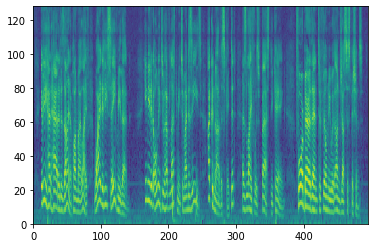

In [105]:
plt.pcolormesh(np.log(mel.numpy()[0]))

In [27]:
import numpy as np

In [23]:
mel.shape

torch.Size([1, 128, 214])

<AxesSubplot:>

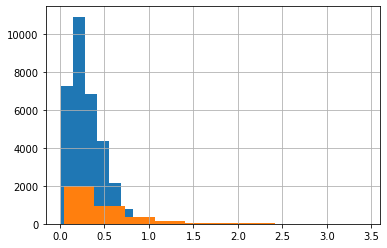

In [57]:
speech_df.utt_time.hist()

nonspeech_df.utt_time.hist()